In [1]:
import sys #only needed to determine Python version number
print('Python version ' + sys.version)

Python version 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


# M62 TP 4 - Étude de la convergence

In [2]:
%reset -f
%matplotlib inline
%autosave 300

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

from scipy.optimize import fsolve

import sympy as sym
sym.init_printing()

Autosaving every 300 seconds


## Exercice



Considérons le problème de Cauchy

>trouver la fonction $y \colon I\subset \mathbb{R} \to \mathbb{R}$ définie sur l'intervalle $I=[0,1]$ telle que $$ \begin{cases} y'(t) = y(t), &\forall t \in I=[0,1], \\ y(0) = 1 \end{cases} $$ dont la solution est $y(t)=e^{t}$. 
>
>Estimer l'ordre de convergence des méthodes:
>
>1. EE, AB$_2$, AB$_3$, AB$_4$, AB$_5$, N$_2$, N$_3$, N$_4$, EM, RK4$_1$, RK6$_5$, RK7$_6$ 
>2. EI, CN, AM$_2$, AM$_3$, AM$_4$, AM$_5$, MA$_2$, BDF$_2$, BDF$_3$, RK1_M
>3. Heun, AM$_4$-AB$_1$, AM$_4$-AB$_2$, AM$_4$-AB$_3$

    
Remarque: puisque la fonction $\varphi(t,y)=y$ est linéaire, toute méthode implicite peut être rendue explicite par un calcul élémentaire en explicitant directement pour chaque schéma l'expression de $u_{n+1}$. Cependant, nous pouvons utiliser le le module `SciPy` sans modifier l'implémentation des schémas (mais on payera l'ordre de convergence de `fsolve`).

**Attention: les schémas multistep ont besoin d'initialiser plusieurs pas de la suite définie pas récurrence pour pouvoir démarrer. 
Dans cette étude, au lieu d'utiliser un schéma d'ordre inférieur pour initialiser la suite, on utilisera la solution exacte (en effet, l'utilisation d'un schéma d'ordre inférieur dégrade l'ordre de précision).**

<details> <summary> Rappels de la démarche pour le calcul de l'orde de convergence.</summary>
    
+ On écrit les schémas numériques :
    + les nœuds d'intégration $[t_0,t_1,\dots,t_{N}]$ sont contenus dans le vecteur `tt` (qui change en fonction de `h`) 
    + les valeurs $[u_0,u_1,\dots,u_{N}]$ pour chaque méthode sont contenues dans le vecteur `uu`.
+ Pour chaque schéma, on calcule la solution approchée avec différentes valeurs de $h_k=1/N_k$. On sauvegarde les valeurs de $h_k$ dans le vecteur `H`. 
+ Pour chaque valeur de $h_k$, on calcule le maximum de la valeur absolue de l'erreur et on sauvegarde toutes ces erreurs dans le vecteur `err_schema` de sort que `err_schema[k]` contient $e_k=\max_{i=0,\dots,N_k}|y(t_i)-u_{i}|$. 
+ Pour afficher l'ordre de convergence on utilise une échelle logarithmique, i.e. on représente $\ln(h)$ sur l'axe des abscisses et $\ln(\text{err})$ sur l'axe des ordonnées.  
 En effet, si $\text{err}=Ch^p$ alors $\ln(\text{err})=\ln(C)+p\ln(h)$.  
 En échelle logarithmique, $p$ représente donc la pente de la ligne droite $\ln(\text{err})$.

</details>

## Schémas explicites

###  Schéma de Adam-Bashforth à 1 pas =  schéma d'Euler progressif
$$
\begin{cases}
u_0=y_0,\\
u_{n+1}=u_n+h\varphi(t_n,u_n)& n=0,1,2,\dots  N-1
\end{cases}
$$

In [3]:
def EE(phi,tt,sol_exacte):
    h = tt[1]-tt[0]
    uu = np.zeros_like(tt)
    # initialisation
    uu[0] = sol_exacte(tt[0])
    # recurrence
    for i in range(len(tt)-1):
        uu[i+1] = uu[i]+h*phi(tt[i],uu[i])
    return uu

### Schéma de Adam-Bashforth à 2 pas
$$
\begin{cases}
u_0=y_0,\\
u_{1}=y_1,\\
u_{n+1}=u_n+\frac{h}{2}\Bigl(3\varphi(t_n,u_n)-\varphi(t_{n-1},u_{n-1})\Bigr)& n=1,2,3,4,5,\dots  N-1
\end{cases}
$$

In [4]:
def AB2(phi,tt,sol_exacte):
    h = tt[1]-tt[0]
    uu = np.zeros_like(tt)
    # initialisation
    for i in (0,1):
        uu[i] = sol_exacte(tt[i])
    # recurrence
    for i in range(1,len(tt)-1):
        k1 = phi( tt[i], uu[i] )
        k2 = phi( tt[i-1], uu[i-1] )
        uu[i+1] = uu[i] + (3*k1-k2)*h/2
    return uu

### Schéma de Adam-Bashforth à 3 pas
$$
\begin{cases}
u_0=y_0,\\
u_{1}=y_1,\\
u_{2}=y_2,\\
u_{n+1}=u_n+\frac{h}{12}\Bigl(23\varphi(t_n,u_n)-16\varphi(t_{n-1},u_{n-1})+5\varphi(t_{n-2},u_{n-2})\Bigr)& n=2,3,4,5,\dots  N-1
\end{cases}
$$

### Schéma de Adam-Bashforth à 4 pas
$$
\begin{cases}
u_0=y_0,\\
u_{1}=y_1,\\
u_{2}=y_2,\\
u_{3}=y_3,\\
u_{n+1}=u_n+\frac{h}{24}\Bigl(55\varphi(t_n,u_n)-59\varphi(t_{n-1},u_{n-1})+37\varphi(t_{n-2},u_{n-2})-9\varphi(t_{n-3},u_{n-3})\Bigr)& n=3,4,5,\dots  N-1
\end{cases}
$$

### Schéma de Adam-Bashforth à 5 pas
$$
\begin{cases}
u_0=y_0,\\
u_{1}=y_1,\\
u_{2}=y_2,\\
u_{3}=y_3,\\
u_{4}=y_4,\\
u_{n+1}=u_n+\frac{h}{720}\Bigl(1901\varphi(t_n,u_n)-2774\varphi(t_{n-1},u_{n-1})+2616\varphi(t_{n-2},u_{n-2})-1274\varphi(t_{n-3},u_{n-3})+251\varphi(t_{n-4},u_{n-4})\Bigr)& n=4,5,\dots  N-1
\end{cases}
$$

### Schéma de Nylström à 2 pas
$$
\begin{cases}
u_0=y_0,\\
u_{1}=y_1,\\
u_{n+1}=u_{n-1}+2h\varphi(t_{n},u_{n})& n=1,2,3,4,5,\dots  N-1
\end{cases}
$$

### Schéma de Nylström à 3 pas
$$
\begin{cases}
u_0=y_0,\\
u_{1}=y_1,\\
u_{2}=y_2,\\
u_{n+1}=u_{n-1}+\frac{h}{3}\Bigl(7\varphi(t_{n},u_{n})-2\varphi(t_{n-1},u_{n-1})+\varphi(t_{n-2},u_{n-2})\Bigr)& n=2,3,4,5,\dots  N-1
\end{cases}
$$

### Schéma de Nylström à 4 pas
$$
\begin{cases}
u_0=y_0,\\
u_{1}=y_1,\\
u_{2}=y_2,\\
u_{3}=y_3,\\
u_{n+1}=u_{n-1}+\frac{h}{3}\Bigl(8\varphi(t_{n},u_{n})-5\varphi(t_{n-1},u_{n-1})+4\varphi(t_{n-2},u_{n-2})-\varphi(t_{n-3},u_{n-3})\Bigr)& n=3,4,5,\dots  N-1
\end{cases}
$$

### Schéma d'Euler modifié
$$
\begin{cases}
u_0=y_0,\\
\tilde u = u_n+\frac{h}{2}\varphi(t_n,u_n),\\
u_{n+1}=u_n+h\varphi\left(t_n+\frac{h}{2},\tilde u\right)& n=0,1,2,\dots  N-1
\end{cases}
$$

In [5]:
def EM(phi,tt,sol_exacte):
    h = tt[1]-tt[0]
    uu = np.zeros_like(tt)
    # initialisation
    uu[0] = sol_exacte(tt[0])
    # recurrence
    for i in range(len(tt)-1):
        k1 = phi( tt[i], uu[i] )
        uu[i+1] = uu[i]+h*phi(tt[i]+h/2,uu[i]+k1*h/2)
    return uu



### Schéma de Runge-Kutta RK4-1
$$\begin{cases}
u_0        = y_0 \\
K_1     = \varphi\left(t_n,u_n\right)\\
K_2     = \varphi\left(t_n+\frac{h}{2},u_n+\frac{h}{2} K_1)\right)\\
K_3     = \varphi\left(t_n+\frac{h}{2},u_n+\frac{h}{2}K_2\right)\\
K_4     = \varphi\left(t_{n+1},u_n+h K_3\right)\\
u_{n+1} = u_n + \frac{h}{6}\left(K_1+2K_2+2K_3+K_4\right) & n=0,1,\dots N-1
\end{cases}
$$

### Schéma de Runge-Kutta RK6_5 (Butcher à 6 étages d'ordre 5)
$$\begin{array}{c|cccccc} 0   & 0 & 0 & 0 & 0 &0&0 \\ \frac{1}{4} & \frac{1}{4} & 0&0&0&0&0\\ \frac{1}{4} & \frac{1}{8} &\frac{1}{8}&0&0&0&0\\ \frac{1}{2} & 0 &-\frac{1}{2}&1&0&0&0\\ \frac{3}{4} & \frac{3}{16} &0&0&\frac{9}{16}&0&0\\ 1 & \frac{-3}{7} &\frac{2}{7}&\frac{12}{7}&\frac{-12}{7}&\frac{8}{7}&0\\ \hline   & \frac{7}{90} & 0&\frac{32}{90} & \frac{12}{90} & \frac{32}{90} & \frac{7}{90} \end{array}$$

<!---
$$\begin{cases}
u_0=y(t_0)=y_0,\\
\tilde u_{n+1/2}=u_n+\frac{h}{2} \varphi(t_{n},u_{n}),\\
\check u_{n+1/2}=u_n+\frac{h}{2} \varphi(t_{n}+\frac{h}{2},\tilde u_{n+1/2}),\\
\hat u_{n+1}=u_n+h\varphi(t_{n+1},\check u_{n+1/2}),\\
u_{n+1}=u_n+\frac{h}{6}\left(\varphi(t_{n},u_{n})+2\varphi(t_{n}+\frac{h}{2},\tilde u_{n+1/2} )+2\varphi(t_{n}+\frac{h}{2}, \check u_{n+1/2})+\varphi(t_{n+1},\hat u_{n+1}  \right)& n=0,1,2,\dots  N-1
\end{cases}
$$
--->

### Schéma de Runge-Kutta RK7_6 (Butcher à 7 étages d'ordre 6)
$$
\begin{array}{c|ccccccc} 
0   & 0 & 0 & 0 & 0 &0&0&0 \\ 
\frac{1}{2} & \frac{1}{2} & 0&0&0&0&0&0\\ 
\frac{2}{3} & \frac{2}{9} &\frac{4}{9}&0&0&0&0&0\\ 
\frac{1}{3} & \frac{7}{36} &\frac{2}{9}&-\frac{1}{12}&0&0&0&0\\ 
\frac{5}{6} & -\frac{35}{144} &-\frac{55}{36}&\frac{35}{48}&\frac{15}{8}&0&0&0\\ 
\frac{1}{6} & -\frac{1}{360} &-\frac{11}{36}&-\frac{1}{8}&\frac{1}{2}&\frac{1}{10}&0&0\\ 
1 & \frac{-41}{260} &\frac{22}{13}&\frac{43}{156}&-\frac{118}{39}&\frac{32}{195}&\frac{80}{39}&0\\ 
\hline   
   & \frac{13}{200} & 0&\frac{11}{40} & \frac{11}{40} & \frac{4}{25} & \frac{4}{25} & \frac{13}{200} \end{array}$$

<!---
$$\begin{cases}
u_0=y(t_0)=y_0,\\
\tilde u_{n+1/2}=u_n+\frac{h}{2} \varphi(t_{n},u_{n}),\\
\check u_{n+1/2}=u_n+\frac{h}{2} \varphi(t_{n}+\frac{h}{2},\tilde u_{n+1/2}),\\
\hat u_{n+1}=u_n+h\varphi(t_{n+1},\check u_{n+1/2}),\\
u_{n+1}=u_n+\frac{h}{6}\left(\varphi(t_{n},u_{n})+2\varphi(t_{n}+\frac{h}{2},\tilde u_{n+1/2} )+2\varphi(t_{n}+\frac{h}{2}, \check u_{n+1/2})+\varphi(t_{n+1},\hat u_{n+1}  \right)& n=0,1,2,\dots  N-1
\end{cases}
$$
--->

## Schémas implicites

### Schéma d'Euler régressif
$$
\begin{cases}
u_0=y_0,\\
u_{n+1}=u_n+h\varphi(t_{n+1},u_{n+1})& n=0,1,2,\dots  N-1
\end{cases}
$$
avec $u_{n+1}$ zéro de la fonction $$x\mapsto -x+u_n+h\varphi(t_{n+1},x).$$

In [6]:
def EI(phi,tt,sol_exacte):
    h = tt[1]-tt[0]
    uu = np.zeros_like(tt)
    # initialisation
    uu[0] = sol_exacte(tt[0])
    # recurrence
    for i in range(len(tt)-1):
        temp = fsolve(lambda x: -x+uu[i]+h*phi(tt[i+1],x), uu[i])
        uu[i+1] = temp[0]
    return uu

### Schéma de Crank-Nicolson
$$
\begin{cases}
u_0=y_0,\\
u_{n+1}=u_n+\frac{h}{2}\Bigl(\varphi(t_n,u_n)+\varphi(t_{n+1},u_{n+1})\Bigr)& n=0,1,2,\dots  N-1
\end{cases}
$$
avec $u_{n+1}$ un zéro de la fonction $x\mapsto -x+u_n+\frac{h}{2}(\varphi(t_n,u_n)+\varphi(t_{n+1},x))$.

In [7]:
def CN(phi,tt,sol_exacte):
    h = tt[1]-tt[0]
    uu = np.zeros_like(tt)
    # initialisation
    uu[0] = sol_exacte(tt[0])
    # recurrence
    for i in range(len(tt)-1):
        temp = fsolve(lambda x: -x+uu[i]+0.5*h*( phi(tt[i+1],x)+phi(tt[i],uu[i]) ), uu[i])
        uu[i+1] = temp[0]
    return uu

### Schéma de AM-2
$$
\begin{cases}
u_0=y_0,\\
u_1=y_1,\\
u_{n+1}=u_n+\frac{h}{12}\Bigl(5\varphi(t_{n+1},u_{n+1})+8\varphi(t_n,u_n)-\varphi(t_{n-1},u_{n-1})\Bigr)& n=1,2,\dots  N-1
\end{cases}
$$

In [8]:
def AM2(phi,tt,sol_exacte):
    h = tt[1]-tt[0]
    uu = np.zeros_like(tt)
    # initialisation
    for i in range(2): 
        uu[i] = sol_exacte(tt[i])
    # recurrence
    for i in range(1,len(tt)-1):
        temp = fsolve(lambda x: -x+uu[i]+h*( 5*phi(tt[i+1],x)+8*phi(tt[i],uu[i])-phi(tt[i-1],uu[i-1]) )/12, uu[i])
        uu[i+1] = temp[0]
    return uu

### Schéma de AM-3
$$
\begin{cases}
u_0=y_0,\\
u_1=y_1,\\
u_{2}=y_2,\\
u_{n+1}=u_n+\frac{h}{24}\Bigl(9\varphi(t_{n+1},u_{n+1})+19\varphi(t_n,u_n)-5\varphi(t_{n-1},u_{n-1})+\varphi(t_{n-2},u_{n-2})\Bigr)& n=2,3,\dots  N-1
\end{cases}
$$

### Schéma de AM-4
$$
\begin{cases}
u_0=y_0,\\
u_1=y_1,\\
u_{2}=y_2,\\
u_{3}=y_3,\\
u_{n+1}=u_n+\frac{h}{720}\Bigl(251\varphi(t_{n+1},u_{n+1})+646\varphi(t_n,u_n)-264\varphi(t_{n-1},u_{n-1})+106\varphi(t_{n-2},u_{n-2})-19\varphi(t_{n-3},u_{n-3})\Bigr)& n=3,4,\dots  N-1
\end{cases}
$$

### Schéma de AM-5
$$
\begin{cases}
u_0=y_0,\\
u_1=y_1,\\
u_{2}=y_2,\\
u_{3}=y_3,\\
u_{4}=y_4,\\
u_{n+1}=u_n+\frac{h}{1440}\Bigl(475\varphi(t_{n+1},u_{+1})+1427\varphi(t_n,u_n)-798\varphi(t_{n-1},u_{n-1})+482\varphi(t_{n-2},u_{n-2})-173\varphi(t_{n-3},u_{n-3})+27\varphi(t_{n-4},u_{n-4})\Bigr),& n=4,5,\dots  N-1
\end{cases}
$$

### Schéma MS-2
$$
\begin{cases}
u_0=y_0,\\
u_1=y_1,\\
u_{n+1}=u_{n-1}+\frac{h}{3}\Bigl(\varphi(t_{n+1},u_{n+1})+4\varphi(t_n,u_n)+\varphi(t_{n-1},u_{n-1})\Bigr)& n=1,2,\dots  N-1
\end{cases}
$$

### Schéma BDF2
$$
\begin{cases}
u_0=y_0,\\
u_1=y_1,\\
u_{n+1}=\frac{4}{3}u_n-\frac{1}{3}u_{n-1}+\frac{2}{3}h\varphi(t_{n+1},u_{n+1})& n=1,2,\dots  N-1
\end{cases}
$$

### Schéma BDF3
$$
\begin{cases}
u_0=y_0,\\
u_1=y_1,\\
u_{2}=y_2,\\
u_{n+1}=\frac{18}{11}u_n-\frac{9}{11}u_{n-1}+\frac{2}{11}u_{n-2}+\frac{6}{11}h\varphi(t_{n+1},u_{n+1})& n=2,3,\dots  N-1
\end{cases}
$$

### Schéma RK1_M:
$$
\begin{cases}
u_0=y_0,\\
u_{n+1}=u_n+h\varphi\left(\frac{t_n+t_{n+1}}{2},\frac{u_n+u_{n+1}}{2}\right)& n=0,1,2,\dots  N-1
\end{cases}
$$

## Schémas predicteur-correcteur

### Schéma de Heun
$$
\begin{cases}
u_0=y_0,\\
\tilde u = u_n+h\varphi(t_n,u_n)\\
u_{n+1}=u_n+\frac{h}{2}\Bigl(\varphi(t_n,u_n)+\varphi(t_{n+1},\tilde u)\Bigr)& n=0,1,2,\dots  N-1
\end{cases}
$$

In [9]:
def heun(phi,tt,sol_exacte):
    h = tt[1]-tt[0]
    uu = np.zeros_like(tt)
    # initialisation
    uu[0] = sol_exacte(tt[0])
    # recurrence
    for i in range(len(tt)-1):
        k1 = phi( tt[i], uu[i] )
        k2 = phi( tt[i+1], uu[i] + k1*h  )
        uu[i+1] = uu[i] + (k1+k2)*h/2
    return uu

### Schéma AM-2 AB-1
$$
\begin{cases}
u_0=y_0,\\
u_1=y_1,\\
\tilde u=u_n+h\varphi(t_n,u_n),\\
u_{n+1}=u_n+\frac{h}{12}\Bigl(5\varphi(t_{n+1},\tilde u)+8\varphi(t_n,u_n)-\varphi(t_{n-1},u_{n-1})\Bigr)& n=1,2,\dots  N-1
\end{cases}
$$

### Schéma AM-3 AB-2
$$
\begin{cases}
u_0=y_0,\\
u_1=y_1,\\
u_2=y_2,\\
\tilde u=u_n+\frac{h}{2}(3\varphi(t_n,u_n)-\varphi(t_{n-1},u_{n-1})),\\
u_{n+1}=u_n+\frac{h}{24}\Bigl(9\varphi(t_{n+1},\tilde u)+19\varphi(t_n,u_n)-5\varphi(t_{n-1},u_{n-1})+\varphi(t_{n-2},u_{n-2})\Bigr)& n=2,3,\dots  N-1
\end{cases}
$$

### Schéma AM-4 AB-2/3/4/5
Écrire et implémenter les schémas AM-4 AB-2, AM-4 AB-3, AM-4 AB-4, AM-4 AB-5.

## Convergence

On initialise le problème de Cauchy, on définit l'équation différentielle (`phi` est une fonction python qui contient la fonction mathématique $\varphi(t, y)$ dépendant des variables $t$ et $y$) et enfin on définit la solution exacte:

In [10]:
t0, y0, tfinal = 0, 1, 3

# CHOIX DU CAS TEST

sol_exacte = lambda t: np.exp(t)
phi = lambda t,y: y

# sol_exacte = lambda t: np.exp(-t)
# phi = lambda t,y: -y

# sol_exacte = lambda t: np.sqrt(2*t+1)
# phi = lambda t,y: 1/y

# sol_exacte = lambda t: np.sqrt(t**2+1)
# phi = lambda t,y: t/y

# sol_exacte = lambda t: 1/np.sqrt(1-2*t)
# phi = lambda t,y: y**3

Pour chaque schéma, on calcule la solution approchée avec différentes valeurs de $h_k=1/N_k$; on sauvegarde les valeurs de $h_k$ dans le vecteur `H`. 

Pour chaque valeur de $h_k$, on calcule le maximum de la valeur absolue de l'erreur et on sauvegarde toutes ces erreurs dans le vecteur `err_schema` de sort que `err_schema[k]` contient $e_k=\max_{i=0,...,N_k}|y(t_i)-u_{i}|$.

Nous pouvons utiliser deux méthodes différentes pour stocker ces informations. 

### Méthode 1

La première méthode est celle utilisée lors des deux premiers TP: on crée autant de listes que de solutions approchées.

In [11]:
H = []

err_ep   = []
err_AB2  = []

err_er   = []
err_CN   = []

err_em   = []
err_heun = []

N = 10
for k in range(6):
    N += 50 #2**(k+3)
    tt = np.linspace(t0,tfinal,N+1)
    h = tt[1]-tt[0]
    H.append(h)
    yy = np.array([sol_exacte(t) for t in tt])
    
    # schemas explicites
    uu_ep   = EE(phi,tt,sol_exacte)
    uu_AB2  = AB2(phi,tt,sol_exacte) # multipas explicite lineaire
    uu_em   = EM(phi,tt,sol_exacte)  # Runge-Kutta explicite
    # schemas implicites
    uu_er   = EI(phi,tt,sol_exacte) 
    uu_CN   = CN(phi,tt,sol_exacte) # multipas implicite lineaire
    # schemas predictor-corrector
    uu_heun = heun(phi,tt,sol_exacte) # CN_EE
    
    # erreurs
    err_ep.append(np.linalg.norm(uu_ep-yy,np.inf))
    err_AB2.append(np.linalg.norm(uu_AB2-yy,np.inf))
    err_em.append(np.linalg.norm(uu_em-yy,np.inf))
    
    err_er.append(np.linalg.norm(uu_er-yy,np.inf))
    err_CN.append(np.linalg.norm(uu_CN-yy,np.inf))
    
    err_heun.append(np.linalg.norm(uu_heun-yy,np.inf))

Pour estimer l'ordre de convergence on estime la pente de la droite qui relie l'erreur au pas $k$ à l'erreur au pas $k+1$ en echelle logarithmique en utilisant la fonction `polyfit` basée sur la régression linéaire.     

In [12]:
print (f'EE    {np.polyfit(np.log(H),np.log(err_ep),    1)[0]:1.2f}' )
print (f'AB2   {np.polyfit(np.log(H),np.log(err_AB2),   1)[0]:1.2f}'  )
print (f'EM    {np.polyfit(np.log(H),np.log(err_em),    1)[0]:1.2f}' )
print('\n')
print (f'EI   {np.polyfit(np.log(H),np.log(err_er),   1)[0]:1.2f}' )
print (f'CN   {np.polyfit(np.log(H),np.log(err_CN),   1)[0]:1.2f}' )
print('\n')
print (f'Heun    {np.polyfit(np.log(H),np.log(err_heun),   1)[0]:1.2f}' )

EE    0.97
AB2   1.98
EM    1.98


EI   1.04
CN   2.00


Heun    1.98


Si on note

- $\omega_{[C]}$ l'ordre du corrector (schéma implicite) 
- $\omega_{[P]}$ l'ordre du predictor (schéma explicite)   

alors l'ordre du schéma predictor-corrector est
$$\omega_{[PC]}=\min\{\omega_{[C]},\omega_{[P]}+1\}$$

**Pour les schémas AM4-ABx, le schéma corrector est d'ordre $p=5$, pour ne pas perdre en ordre convergence il faut choisir un schéma predictor d'ordre $p-1$ (ici AB4).**

Pour afficher l'ordre de convergence on utilise une échelle logarithmique : on représente $\ln(h)$ sur l'axe des abscisses et $\ln(\text{err})$ sur l'axe des ordonnées. Le but de cette représentation est clair: si $\text{err}=Ch^p$ alors $\ln(\text{err})=\ln(C)+p\ln(h)$. En échelle logarithmique, $p$ représente donc la pente de la ligne droite $\ln(\text{err})$.

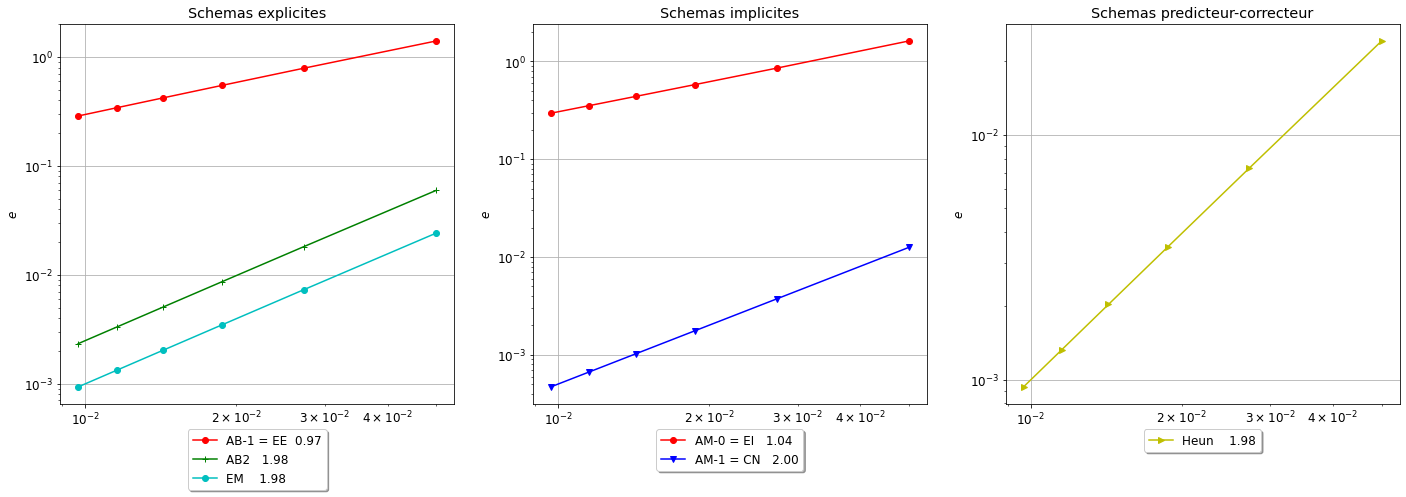

In [13]:
plt.figure(figsize=(24,7))

plt.subplot(1,3,1)
plt.loglog(H,err_ep,    'r-o',label=f'AB-1 = EE  {np.polyfit(np.log(H),np.log(err_ep),    1)[0]:1.2f}')
plt.loglog(H,err_AB2,   'g-+',label=f'AB2   {np.polyfit(np.log(H),np.log(err_AB2),   1)[0]:1.2f}')

plt.loglog(H,err_em,    'c-o',label=f'EM    {np.polyfit(np.log(H),np.log(err_em),    1)[0]:1.2f}')
plt.xlabel('$h$')
plt.ylabel('$e$')
plt.title("Schemas explicites")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=1)
plt.grid(True)

plt.subplot(1,3,2)
plt.loglog(H,err_er,  'r-o',label=f'AM-0 = EI   {np.polyfit(np.log(H),np.log(err_er),   1)[0]:1.2f}')
plt.loglog(H,err_CN,  'b-v',label=f'AM-1 = CN   {np.polyfit(np.log(H),np.log(err_CN),   1)[0]:1.2f}')
plt.xlabel('$h$')
plt.ylabel('$e$')
plt.title("Schemas implicites")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=1)
plt.grid(True)

plt.subplot(1,3,3)
plt.loglog(H,err_heun,   'y->',label=f'Heun    {np.polyfit(np.log(H),np.log(err_heun),   1)[0]:1.2f}')
plt.xlabel('$h$')
plt.ylabel('$e$')
plt.title("Schemas predicteur-correcteur")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=1)
plt.grid(True)